# Lab. TRIL - Carbon Capture and Storage

Engenharia Computacional para a Emissão Zero no Setor de Óleo e Gás

## Introdução 

Esse é um programa que realiza um processo de leitura, processamento e análise de um conjunto de dados de um reservatório, para encontrar classes de injetividade apresentadas com análise de gráfico.

Esse projeto é desenvolvido por:<br>
* Yhasmim de Souza Tigre - Aluna de Iniciação Científica - UFPB
* Prof. Dr. Gustavo C. Oliveira - Professor Orientador - UFPB


### Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline 
#from matplotlib.pyplot import plotpip 

In [3]:
import warnings

#Serve para ignorar os 'red warnings' que algumas bibliotecas apontam porque tem novas versoes de implementacao
warnings.filterwarnings('ignore') 

## 1 - Preparação de Files 

Essas funções devem receber arquivos csv (em uma formatação pré-estabelecida) que serem lidos, checados e iniciados.<br>
Os arquivos precisam:
* ter colunas nomeadas 
* não ter valores NAN
* ter colunas na ordem correta (RQI, pressao, pressao_inversa, distancia, permeabilidade e porosidade)
* ter colunas com valores numéricos

In [4]:
'''função de leitura do arquivo csv para df'''

def read_df(df):

    df = pd.read_csv(df)
    if any(df.isna()):
        print("df com valores NAN")
        
        df = df.fillna(0)
        print("df corrigido, não mais possui valores NAN")

    #remove values of 0
    df = df[(df.T != 0.00000).any()] #talvez seja necessario modificar, pode atrapalhar quando tiver outras colunas 
    #df = df.loc[(df!=0).any(axis=1)]
    print("df corrigido, não mais possui valores 0")
    
    print(df)
    return df

In [4]:
'''função de checagem de keys em dataframe '''

def checking(df):
    
    df = read_df(df)

    lista_primarias = ['RQI','pressao','pressao_inversa','distancia','permeabilidade','porosidade']
    lista_Js = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8']  
    
    #encontrando keys estrangeiras no df
    for i in df.keys():         
        if lista_primarias.count(i) == 0: 
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')                 
        if lista_Js.count(i) == 0:
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis secundarias Js. \n')

    #encontrando keys faltantes no df
    for i in lista_primarias:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel primaria "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')
    for i in lista_Js:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel secundária "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis secundária Js. \n')
        
    return df

## 2 - Calculo dos J's

Aqui criamos funções qualificadoras, que utilizam os atributos do df para categorizar J's.

In [130]:
'''função de normalização dos dados'''

def normalization(df, J, norm=False):

    #df = read_df(df)
    # df = checking(df)
    
    #atribuição        
    for j in J: 
              
        if j == 'J1':
            J1 = df['RQI']
            df['J1'] = J1
            normalize_(df, j, norm)            
                    
        if j == 'J2':
            J2 = df['RQI']*df['pressao']
            df['J2'] = J2
            normalize_(df, j, norm)

        if j == 'J3':
            J3 = df['RQI']*df['pressao_inversa']
            df['J3'] = J3
            normalize_(df, j, norm)                                                                                         
                            
        if j == 'J4':
            #para evitar resultados infinitos
            aux = np.log(df['distancia']) #calc do log(0 ind, 1 inf)
            #mascara
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J4 = df['RQI'] * df['pressao'] * aux      
            df['J4'] = J4
            normalize_(df, j, norm) 

        if j == 'J5':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J5 = df['RQI'] * df['pressao_inversa'] * aux
            df['J5'] = J5
            normalize_(df, j, norm)
        
        if j == 'J6':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J6 = df['permeabilidade'] * df['porosidade'] * aux
            df['J6'] = J6
            normalize_(df, j, norm)  

    return df

def normalize_(df, col, norm):
    if norm == True:   
        df[f'{col}_normalizado'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

## 3- Processamento Binning <br> (Bayesian Blocks ou KDE)
<br/>

A classe binning é responsável por processar os dados em KDE ou Bayesian Blocks 

#@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit

In [6]:
"""Processamento de dados em binning"""
class binning():

        #método construtor
        def __init__(self) -> None:
            pass
        
        #@jit(nopython=True)
        def proc_binning(df, J, binning): 

            if binning == 'kde':
                
                '''Bibliotecas'''
                import numpy as np
                from numpy import linspace
                from sklearn.neighbors import KernelDensity
                from scipy.signal import argrelmin, find_peaks
                from sklearn.model_selection import GridSearchCV, LeaveOneOut
                import scipy.integrate as integrate                        
                                
                '''Recebendo df'''
                #para testes com valores simplificados
                df = read_df(df)

                #para valores ja normalizados
                #df = checking(df)

                #para valores que passarão por normalização
                #df = normalization (df, J, norm=True)

                #pegando um valor menor para rodar o codigo
                df = df.sample(1500)

                '''Método de bandwith para kde'''
                
                ideal_band = 0
                #JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
                JN =  {'J1'}
                
                for coluna in JN:                   
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                
                    band = np.linspace(0.01, 0.05)
                    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
                    grid.fit(X[:,None].reshape(-1, 1)) 
                    ideal_band = grid.best_params_
                    #print(ideal_band)  
                    #BANDWIDTH ORIGINAL: 0.01      
                   
                '''Calculo kde'''
                resultados_kde = {}

                for coluna in JN:                    
                    
                    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)

                    #f, a  = plt.subplots()                    
                    #h = sns.histplot(X, kde = True, element="bars", kde_kws={'bw_method':'silverman', 'bw_adjust':0.1}, ax = a, stat='probability', color= 'white', edgecolor='white', facecolor='white')       
                        
                    # calculo da densidade de probabilidade
                    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

                    #plt.plot(kde)
                    #sns.kdeplot(X, bw_method= 0.01, ax = a, color='black', linewidth=2.5, alpha=0.5)
                    #retorna os pontos em uma distancia equidistante / os dados precisam está em 2D
                    dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

                    #calcula a probabilidade logarítmica de cada amostra sob o modelo                     
                    log = kde.score_samples(dist.reshape(-1, 1))
                    log = np.exp(log)
                    # usamos exponencial para deixar log positivo
                    #essa integral retorna o valor True ou False (estava retornando valor antes das modificações em dist e log)
                    # [:, None] é usado para realizar o broadcast dos dados (operação entre arrays de dimensões diferentes))
                    integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())
                    #print(integral)
                    
                    if integral <= 1.01 and integral >= 0.99:
                        print(f'A integral : {integral} é adequeada.')
                    else:
                        print(f'A integral não está no intervalo correto: {integral}')
                        raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')
                                                           
                    #Calculo das Particoes
                    # calcula os picos
                    peaks = find_peaks(log, height=min(log))
                    peaks = np.array(peaks[1]['peak_heights'])
                    print(peaks)
                    #Calcula a minima relativa dos dados
                    valleys = argrelmin(log)[0]
                    print(valleys)
                    print(type(valleys))
                    
                    #Retorna os indices que classificam o array em ordem crescente
                    ord = np.argsort(np.abs(np.diff(log[valleys])))
                    #inverte a ordem do array 
                    ordValleys_J = np.flip(ord)+1 


                    #Contrução dos intervalos de classe 

                    #utiliza o intervalo de 0 a 1 para encontrar os pontos de partição usando a minima relativa
                    ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))
                    classes = {}
                    for i in range(1, len(ov)):
                        classes[i] = (ov[i-1], ov[i]) 
                    
                    
                    plt.figure(figsize=(20, 12))
                    plt.plot(dist, log, color='black', linewidth=2.5, alpha=0.5)  
                    a_peaks = find_peaks(log, height=min(log))
                    plt.plot(peaks, log[a_peaks[0]], "o")   
                    plt.plot(valleys[0], log[valleys[1]], "o")

                    #retorno de funcão KDE com dicionario
                    resultados_kde[coluna] = {}
                    
                    resultados_kde[coluna]['dist'] = dist
                    resultados_kde[coluna]['log'] = log
                    resultados_kde[coluna]['peaks'] = peaks
                    resultados_kde[coluna]['valleys'] = valleys
                    resultados_kde[coluna]['ordValleys_J'] = ordValleys_J
                    #resultados_kde[coluna]['classes'] = classes

                return resultados_kde   
                
            
            #Calculo Bayesian Blocks

            if binning == 'bb':
                from astropy.stats import bayesian_blocks

                
                resultados_bb = {}

                for coluna in df.columns:
                    if coluna in df.columns[12::]:
                        serie = df.query(f"{coluna} > 0")[coluna]
                        resultados_bb[coluna] = [serie, bayesian_blocks(serie)]

                return resultados_bb
            

In [ ]:
"""Processamento de dados em binning"""
class binning():

        #método construtor
        def __init__(self) -> None:
            pass
        
        #@jit(nopython=True)
        def proc_binning(df, J, binning): 

            if binning == 'kde':
                
                '''Bibliotecas'''
                import numpy as np
                from numpy import linspace
                from sklearn.neighbors import KernelDensity
                from scipy.signal import argrelmin, find_peaks
                from sklearn.model_selection import GridSearchCV, LeaveOneOut
                import scipy.integrate as integrate                        
                
                '''Recebendo df'''
                #para testes com valores simplificados
                df = read_df(df)

                #para valores ja normalizados
                #df = checking(df)

                #para valores que passarão por normalização
                #df = normalization (df, J, norm=True)

                #pegando um valor menor para rodar o codigo
                #df = df.sample(1500)

                '''Método de bandwith para kde'''
                ideal_band = 0
                #JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
                #JN =  {'J2'}

                for coluna in J:                   
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                    X = X[X > 0] 

                    band = np.linspace(0.01, 0.05)
                    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
                    grid.fit(X[:,None].reshape(-1, 1)) 
                    ideal_band = grid.best_params_
                    #print(ideal_band)  
                    #BANDWIDTH ORIGINAL: 0.01    
                
                '''Calculo kde'''
                resultados_kde = {}

                for coluna in J:                    
                    
                    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
                    X = df[f'{coluna}'].values[::]
                    X = X[X > 0].reshape(-1, 1) 
                        
                    # calculo da densidade de probabilidade
                    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

                dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

                log = kde.score_samples(dist.reshape(-1, 1))
                log = np.exp(log)    

                #temos que calcular a integral para verificar se  o kde está correto para ser uma distribuição de probabilidade
                integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())

                if integral <= 1.01 and integral >= 0.99:
                    print(f'A integral : {integral} é adequeada.')
                else:
                    print(f'A integral não está no intervalo correto: {integral}')
                    raise KeyError(f'A integral precisa estar entre 0.99 e 1.01') 
                
                    #retorna tupla com dois arrays, o primeiro com os indices dos picos e o segundo com os valores dos picos
                peaks = find_peaks(log)
                print(peaks)
                #Calcula a minima relativa dos dados
                valleys = argrelmin(log)[0]
                print(valleys)
                print(type(valleys))


                #numero de classes = n-1 (numero dos dedos e espaço dentre os dedos= verdadeira classe)

                #uni os valores do valleys ordenados com 0 e 1 para encontrar os pontos de partição usando a minima relativa
                #ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))

                con = np.concatenate((np.array([0.0]), dist[valleys], np.array([1.0])))
                #calcula a diferença entre os valores de con
                comp_classe = np.diff(con)
                #calcula o desvio padrão
                dp = np.std(comp_classe)    
                #excluindo classes com desvio padrao maior que o desvio padrão
                excl = np.where(comp_classe <= dp)

                #cria uma mascara para excluir os valores de con que estão fora do desvio padrão. True para manter e False para excluir
                mask = np.ones(con.shape,dtype=bool)
                mask[excl] = False
                con = con[mask]

                print(type(con))
                print(con)

                #como dicionario
                classes = {}
                for i in range(1, len(con)):
                    classes[i] = (con[i-1], con[i])
                print(classes)

                classes = pd.DataFrame(classes)

                classes.to_csv('classes_J2_reduzido.csv', index=False)

In [73]:
'''Adição do padding '''

def padding(df, J):

    #df = binning.proc_binning(df, J, binning='kde')

    padDF = np.pad(df, (1, 1)) #para a melhor localização de pontos divisores de classe
    return padDF    

## 4 - Pickle

In [8]:
def pickle (df, fileout):
    import pickle as pkl 

## 5 - Análise dos Gráficos

### Graficos dos Binnings

In [9]:
'''Classe Graficos com funções KDE e BB '''
class graficos:

    #método construtor
    def __init__(self) -> None:
        pass  
     
    '''Função de plotagem do KDE ''' 
    def grafico_kde(df, J, pad = False):        

        import matplotlib.pyplot as plt
        #plt.style.use(".dados/plot/ccs.mplstyle")

        if pad == True:
            df = padding(df)

        #df deve ser aquele resultante do processamento
        #df = binning.proc_binning(proc, J, binning='kde')       

        #dist  'numpy.ndarray'
        #log   'numpy.ndarray'
        #peaks 'tuple'
        #valleys 'numpy.ndarray'
        #ordValleys_J 'numpy.ndarray'
        #classes 'dict'

        for i in df:                        
            plt.plot(df[i]['dist'], df[i]['log'])
            plt.grid(True)            

        for i in J:           
            
            plt.title(f'Vales dos Kernels | {i} normalizado')
            plt.ylabel("Valor da Densidade")
            plt.xlabel(f'Posição assumida por {i} norm')                      
            
            
            plt.plot(df[i]['valleys'], df[i]['log'][df[i]['valleys']], 'o', c='red')
            plt.plot(df[i]['valleys'][df[i]['ordValleys_J'][0:4]], df[i]['log'][df[i]['valleys'][df[i]['ordValleys_J'][0:4]]], '*', c='green')

            #plot das classes
            for j in i:
                plt.plot(df[j]['classes'])

            plt.show()
            plt.savefig(f'./dados/Analise de Js/testes/{J}.jpeg', format='jpeg')

    
                
    '''Função de plotagem do BB ''' 
    def grafico_bb(df, bins_bb, J):

        df = binning.proc_binning(df, J, binning='bb')

        import matplotlib.pyplot as plt
        #plt.style.use(".dados/plot/ccs.mplstyle")

        """
        Essa funcao tem como objetivo criar uma representação gráfica
        de uma determinada 'coluna' de um determinado DataFrame (df)
        dado o calculo de seus bins/classes baseados no Bayesian Blocks.
        Pode-se obter os Bayesian Blocks de uma determinada variável
        usando a funcao 'bayesian_blocks' do módulo astropy.stats
        """
                
        
        labels = {
            "J1_normalizado" : "RQI",
            "J2_normalizado" : "RQI * Pressao",
            "J3_normalizado" : "RQI * Pressao Inversa",
            "J4_normalizado" : "RQI * Pressao * ln(distancia)",
            "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
            "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
            "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
        }
        
        ax = plt.figure(figsize=(20, 12))
        #modificar labels para for
        ax = plt.title(f"Histograma '{J} = {labels[J]}' utilizando blocos bayesianos", fontsize = 24)
        ax = plt.xlabel("X", fontsize = 18)
        ax = plt.ylabel("Y", fontsize = 18)
        ax = plt.hist(df, bins = bins_bb, color='g')
        ax = plt.grid(True)
        plt.savefig(f'./dados/Analise de Js/bb/{J}.jpeg', format='jpeg')
        plt.show(ax)
        

In [10]:
'''#gerando gráficos bb
resultados = {}

for coluna in variaveis_df.columns:
    if coluna in variaveis_df.columns[12::]:
        serie = variaveis_df.query(f"{coluna} > 0")[coluna]
        resultados[coluna] = [serie, bayesian_blocks(serie)]
        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)'''

'#gerando gráficos bb\nresultados = {}\n\nfor coluna in variaveis_df.columns:\n    if coluna in variaveis_df.columns[12::]:\n        serie = variaveis_df.query(f"{coluna} > 0")[coluna]\n        resultados[coluna] = [serie, bayesian_blocks(serie)]\n        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)'

# Testes


In [5]:
import numpy as np
from numpy import linspace
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelmin, find_peaks
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import scipy.integrate as integrate                        
import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.graph_objects as go
#import plotly.express as px

In [123]:
df = read_df("./dados/Simplificados_unisim-i-d/J2_reduzido.csv")
#df = read_df("./dados/J Costa/J1_Costa.csv")
#df = df.sample(1500)

df com valores NAN
df corrigido, não mais possui valores NAN
df corrigido, não mais possui valores 0
           J2
0     0.42121
1     0.41414
2     0.45838
3     0.39962
4     0.34914
...       ...
3311  0.65860
3312  0.66928
3313  0.27292
3314  0.16820
3320  0.43269

[3008 rows x 1 columns]


In [124]:
ideal_band = 0
#JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
JN =  {'J2'}
#df = normalization (df, JN, norm=True)

for coluna in JN:                   
    X = df[f'{coluna}'].values[::].reshape(-1, 1)
    X = X[X > 0] 

    band = np.linspace(0.01, 0.05)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
    grid.fit(X[:,None].reshape(-1, 1)) 
    ideal_band = grid.best_params_
    #print(ideal_band)  
    #BANDWIDTH ORIGINAL: 0.01    

In [127]:
print(ideal_band) 

{'bandwidth': 0.010816326530612244}


In [129]:
'''Calculo kde'''
resultados_kde = {}

for coluna in JN:                    
    
    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
    X = df[f'{coluna}'].values[::]
    X = X[X > 0].reshape(-1, 1) 
           
    # calculo da densidade de probabilidade
    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

In [130]:
dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

In [131]:
log = kde.score_samples(dist.reshape(-1, 1))
log = np.exp(log)                 

In [132]:
#temos que calcular a integral para verificar se  o kde está correto para ser uma distribuição de probabilidade
integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())

if integral <= 1.01 and integral >= 0.99:
                    print(f'A integral : {integral} é adequeada.')
else:
    print(f'A integral não está no intervalo correto: {integral}')
    raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')                                        

A integral : 1.0 é adequeada.


In [133]:
#retorna tupla com dois arrays, o primeiro com os indices dos picos e o segundo com os valores dos picos
peaks = find_peaks(log)
print(peaks)
#Calcula a minima relativa dos dados
valleys = argrelmin(log)[0]
print(valleys)
print(type(valleys))

(array([ 475,  602,  675, 1089, 1155, 1436, 1522, 2057, 2261, 2386],
      dtype=int64), {})
[ 546  664 1034 1134 1389 1491 2024 2210 2324]
<class 'numpy.ndarray'>


In [134]:
#Retorna os indices que classificam o array e calcula o valores absolutos das diferenças entre os valores dos vales e ordena em ordem crescente
"""ord = np.argsort(np.abs(np.diff(log[valleys])))
print(ord)
#inverte a ordem do array 
ordValleys_J = np.flip(ord)+1 
print(ordValleys_J)"""

'ord = np.argsort(np.abs(np.diff(log[valleys])))\nprint(ord)\n#inverte a ordem do array \nordValleys_J = np.flip(ord)+1 \nprint(ordValleys_J)'

In [136]:
#numero de classes = n-1 (numero dos dedos e espaço dentre os dedos= verdadeira classe)

#uni os valores do valleys ordenados com 0 e 1 para encontrar os pontos de partição usando a minima relativa
#ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))

con = np.concatenate((np.array([0.0]), dist[valleys], np.array([1.0])))
#calcula a diferença entre os valores de con
comp_classe = np.diff(con)
#calcula o desvio padrão
dp = np.std(comp_classe)    
#excluindo classes com desvio padrao maior que o desvio padrão
excl = np.where(comp_classe <= dp)

#cria uma mascara para excluir os valores de con que estão fora do desvio padrão. True para manter e False para excluir
mask = np.ones(con.shape,dtype=bool)
mask[excl] = False
con = con[mask]

print(type(con))
print(con)

#como dicionario
classes = {}
for i in range(1, len(con)):
    classes[i] = (con[i-1], con[i])
print(classes)


#como lista
cl = []
for i in range(1, len(con)):
    cl.append(con[i-1])
cl.append(1.0)
print(cl)

<class 'numpy.ndarray'>
[0.         0.22081809 0.37712005 0.49584303 0.77286332 1.        ]
{1: (0.0, 0.22081809112071832), 2: (0.22081809112071832, 0.3771200532091786), 3: (0.3771200532091786, 0.4958430329231792), 4: (0.4958430329231792, 0.772863318922514), 5: (0.772863318922514, 1.0)}
[0.0, 0.22081809112071832, 0.3771200532091786, 0.4958430329231792, 0.772863318922514, 1.0]


In [137]:
classes = pd.DataFrame(classes)
classes

,1,2,3,4,5
0,0.000000,0.220818,0.377120,0.495843,0.772863
1,0.220818,0.377120,0.495843,0.772863,1.000000


In [138]:
#criar csv para salvar as classes in a pasta
classes.to_csv('classes_J2_reduzido.csv', index=False)

In [12]:
#calculo do valor de cada classe
cl = pd.read_csv('classes_J1_reduzido.csv')

#calculo do delta
for i in cl.columns:
    print(cl[i].iloc[1])
    delta = cl[i].iloc[1] - cl[i].iloc[0]
    #adiciona a coluna delta ao dataframe cl
    #adicionar o valor de delta a um dataframe
    delta
    print(delta)
    #cl[i].loc[2] = cl[i].append(pd.Series([[delta]]), ignore_index=True)
    #cl[i].iloc[2] = cl[i].append(pd.DataFrame(delta))
print(cl)    


0.2208180911207183
0.2208180911207183
0.3771200532091786
0.15630196208846028
0.4958430329231792
0.11872297971400064
0.772863318922514
0.2770202859993348
1.0
0.22713668107748597
          1         2         3         4         5
0  0.000000  0.220818  0.377120  0.495843  0.772863
1  0.220818  0.377120  0.495843  0.772863  1.000000


In [71]:
print(dist.shape, log.shape, dist[valleys].shape, log[valleys].shape)

(3008,) (3008,) (10,) (10,)


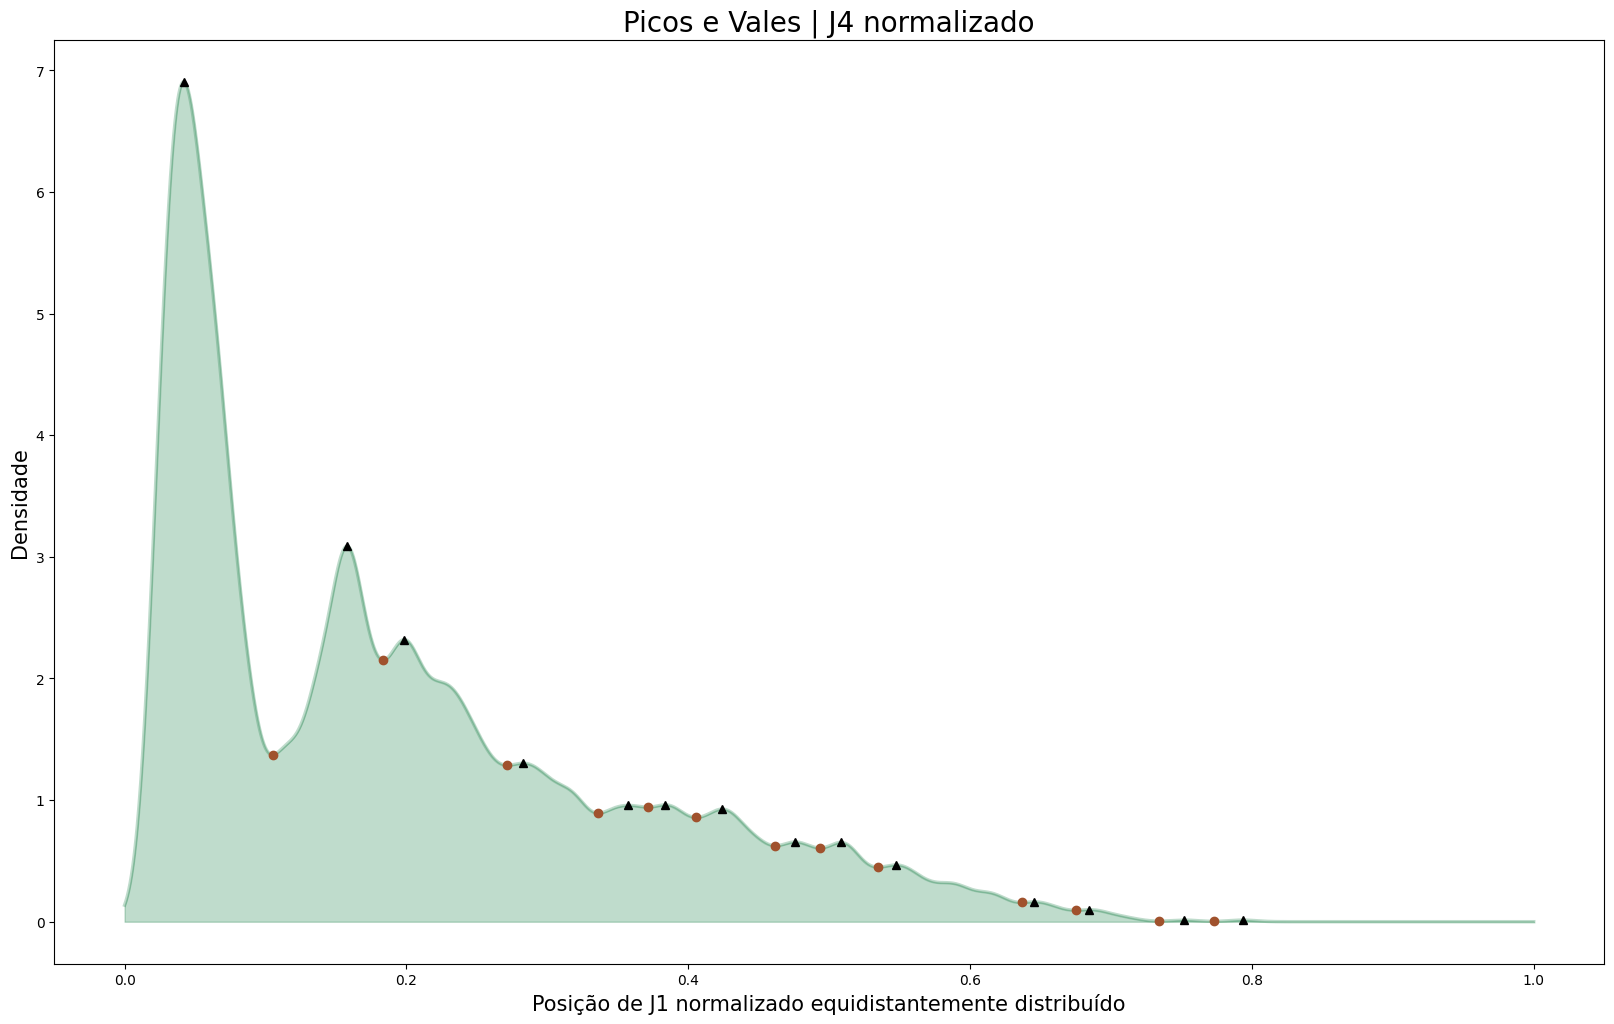

In [37]:
plt.figure(figsize=(20, 12))
plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
plt.fill_between(dist, log, color='seagreen', alpha=0.3)
plt.plot(dist[valleys], log[valleys], "o", color='sienna')
plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='black')

plt.xlabel('Posição de J1 normalizado equidistantemente distribuído', fontsize=15)
plt.ylabel('Densidade', fontsize=15)
plt.title('Picos e Vales | J4 normalizado', fontsize=20)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (8, 2) and (5,)

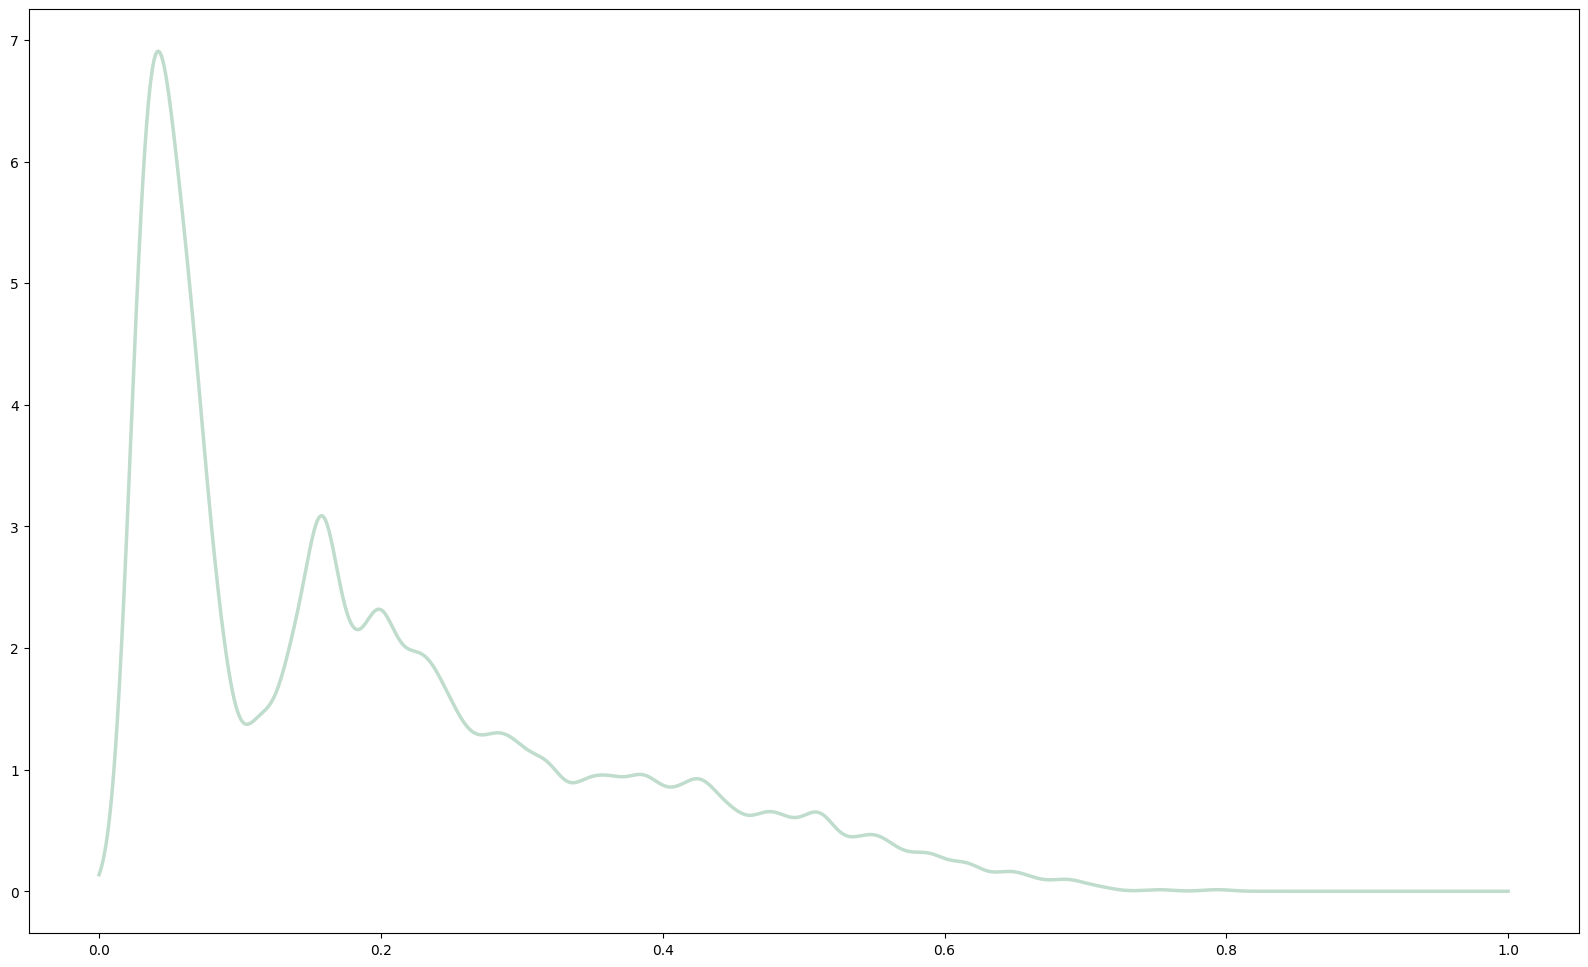

In [38]:
plt.figure(figsize=(20, 12))
plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
#plt.plot(dist[valleys], log[valleys], "o", color='sienna')
#plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='blue')

#plot das classes como lista
myList = classes.items()
myList = sorted(myList)
x, y = zip(*myList)

plt.plot(y, log[:5], 'x',markersize=10, color='peru')

#criando linhas verticais para cada classe
for i in range(1, len(cl)):
    plt.axvline(cl[i], color='peru', linestyle='--')

#para preencher as classes
for i in range(1, len(cl)):
    plt.fill_between(dist, 0, log, where=(dist >= cl[i-1]) & (dist <= cl[i]), color='seagreen', alpha=0.3)

plt.xlabel('Posição de J1 normalizado equidistantemente distribuído', fontsize=15)
plt.ylabel('Densidade', fontsize=15)
plt.title('Classificação do Kernel | J4 normalizado', fontsize=20)
plt.savefig(f'./dados/Analise de Js/simplificados/kde_simplificados/{coluna}_normalizado_Kernel.jpeg', format='jpeg')
plt.show()


#BB

In [19]:
from astropy.stats import bayesian_blocks

coluna = {'J3'}

"""
Essa funcao tem como objetivo criar uma representação gráfica
de uma determinada 'coluna' de um determinado DataFrame (df)
dado o calculo de seus bins/classes baseados no Bayesian Blocks.
Pode-se obter os Bayesian Blocks de uma determinada variável
usando a funcao 'bayesian_blocks' do módulo astropy.stats
"""

def grafico_bb(df, bins_bb, coluna):
    
    labels = {
        "J1_normalizado" : "RQI",
        "J2_normalizado" : "RQI * Pressao",
        "J3_normalizado" : "RQI * Pressao Inversa",
        "J4_normalizado" : "RQI * Pressao * ln(distancia)",
        "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
        "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
        "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
    }
    
    ax = plt.figure(figsize=(20, 12))
    ax = plt.title("Histograma J3 utilizando blocos bayesianos", fontsize = 24)
    #ax = plt.title(f"Histograma '{coluna} = {labels[coluna]}' utilizando blocos bayesianos", fontsize = 24)
    ax = plt.xlabel("X", fontsize = 18)
    ax = plt.ylabel("Y", fontsize = 18)
    ax = plt.hist(df, bins = bins_bb, color='seagreen', alpha=0.3)
    ax = plt.grid(True)
    plt.savefig(f'./dados/Analise de Js/simplificados/bb_simplificados/{coluna}_Bayesian.jpeg', format='jpeg')
    plt.show(ax)


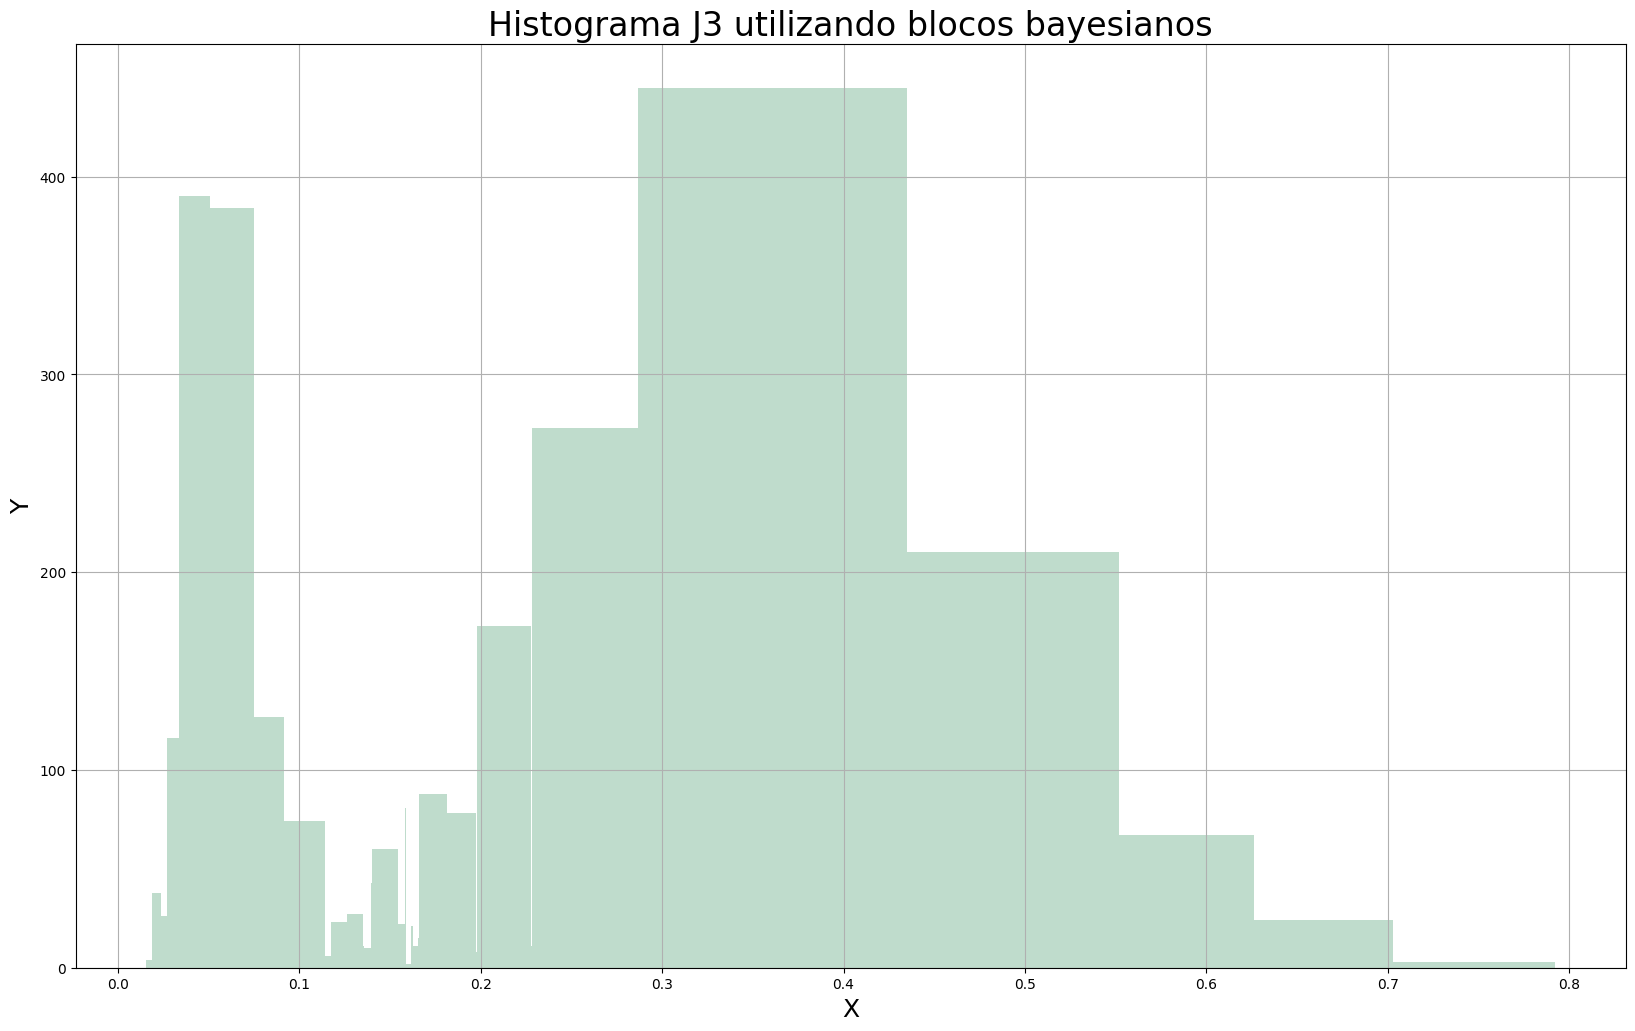

In [20]:
resultados = {}

for coluna in df.columns:
    if coluna in df.columns[0]:
        serie = df.query(f"{coluna} > 0")[coluna]
        resultados[coluna] = [serie, bayesian_blocks(serie)]
        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)